**Deep Learning**

**Practice 3.1 - VAE**

**Marcelo Ferrer - Aymen Merchaoui**


## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [1]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [2]:
import numpy as np
import glob, os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [3]:
# Disable eager execution (eager execution executes TensorFlow operations immediately)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
# Mat plot workaround
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Load the images

In [5]:
DATA_FOLDER = "dataset/img_align_celeba/"
WEIGHTS_FOLDER = 'dataset/weights/'

if not os.path.exists(WEIGHTS_FOLDER):
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [6]:
INPUT_DIM = (64,64,3) # Image dimension
BATCH_SIZE = 256 # Size of the batch
Z_DIM = 200 # Dimension of the latent vector (z)

# Normalization from 0 to 1
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training'
    )

Found 202599 images belonging to 1 classes.


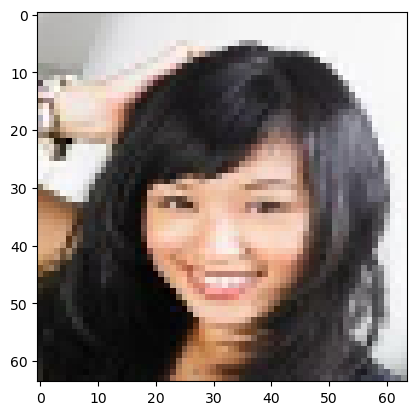

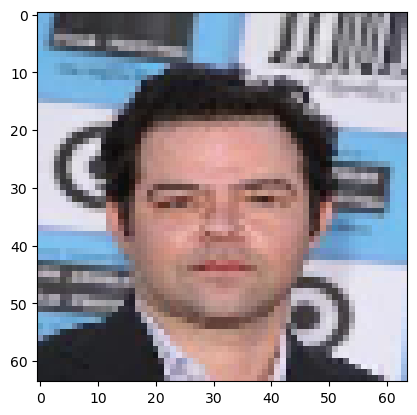

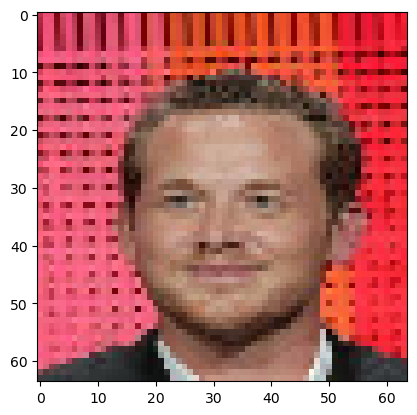

In [7]:
# Display some example images
batch = data_flow.next()
for i in range(0,3):
    image = batch[0][i]
    plt.imshow(image)
    plt.show()

In [8]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

# Creates the encoder with the size and filters passed in the parameters
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    #conv_filters = [32, 64, 64, 64],
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

# TODO show keras visualizer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 32, 32, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 16, 16, 32)   4640        ['leaky_re_lu[0][0]']            
                                                                                              

In [9]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

# Generate the decoder, as a backward mirror of the encoder
decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    #conv_filters = [64,64,32,3],        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 512)               102912    
                                                                 
 reshape (Reshape)           (None, 4, 4, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 8, 8, 32)         9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 16, 16, 32)       9248      
 pose)                                                     

In [10]:
# Generate the model with the encoder and the decoder
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 32, 32, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 16, 16, 32)   4640        ['leaky_re_lu[0][0]']            
                                                                                            

In [11]:
def plot_compare_VAE(images, add_noise=False):
    n_to_show = images.shape[0]

    if add_noise:
        encodings = vae_encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = vae_decoder.predict(encodings)
    else:
        reconst_images = vae.predict(images)

    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='gray')
    plt.show()

In [17]:
hist_loss = []
hist_r_loss = []
hist_kl_loss = []

791/791 [==============================] - 1527s 2s/step - batch: 395.5000 - size: 255.8068 - loss: 418.1509 - r_loss: 0.0370 - kl_loss: 48.1071


c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


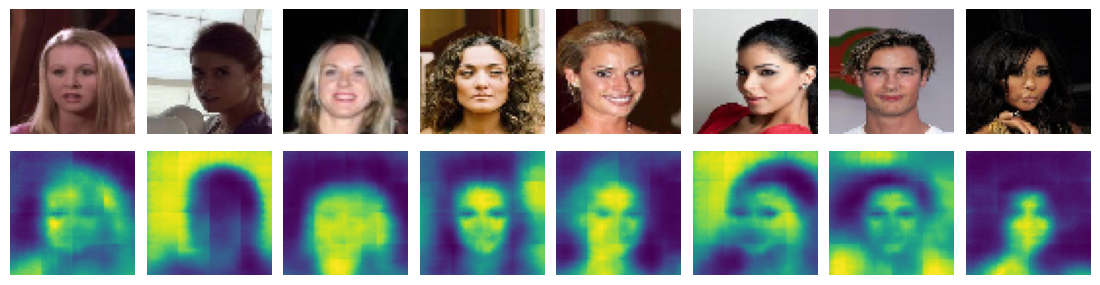

In [12]:
LEARNING_RATE = 0.0005 # Learning rate of the optimizer
N_EPOCHS = 12  # No. of epochs to show advance
N_BLOCKS = 10 # Number of blocks to run (total epochs = N_EPOCHS * N_BLOCKS)
LOSS_FACTOR = 10000

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

# Reconstruction loss, the mean squared error between the input and output images
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

# KL divergence loss
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

# Total loss, weighted sum of the reconstruction loss and the KL divergence loss (LOSS_FACTOR is configurable)
def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

# Takes 8 images to show the results during training
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

# Just run one epoch and plot the images
vae.fit(data_flow, 
    shuffle=True, 
    epochs = 1, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

plot_compare_VAE(example_images) 

Epoch 1/12
791/791 [==============================] - 1396s 2s/step - batch: 395.5000 - size: 255.8068 - loss: 309.7291 - r_loss: 0.0260 - kl_loss: 49.4450
Epoch 2/12
791/791 [==============================] - 142s 180ms/step - batch: 395.5000 - size: 255.8068 - loss: 291.4180 - r_loss: 0.0243 - kl_loss: 48.3242
Epoch 3/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 284.1486 - r_loss: 0.0235 - kl_loss: 48.8693
Epoch 4/12
791/791 [==============================] - 128s 162ms/step - batch: 395.5000 - size: 255.8068 - loss: 280.0138 - r_loss: 0.0231 - kl_loss: 49.4675
Epoch 5/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 277.1896 - r_loss: 0.0227 - kl_loss: 50.0129
Epoch 6/12
791/791 [==============================] - 128s 162ms/step - batch: 395.5000 - size: 255.8068 - loss: 275.0356 - r_loss: 0.0225 - kl_loss: 50.4765
Epoch 7/12
791/791 [==============================] - 

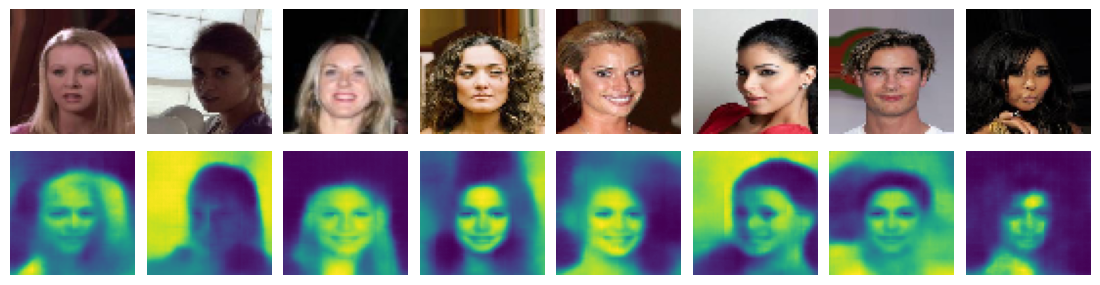

Epoch 1/12
791/791 [==============================] - 125s 158ms/step - batch: 395.5000 - size: 255.8068 - loss: 268.3457 - r_loss: 0.0216 - kl_loss: 52.0020
Epoch 2/12
791/791 [==============================] - 124s 156ms/step - batch: 395.5000 - size: 255.8068 - loss: 267.8227 - r_loss: 0.0216 - kl_loss: 52.1612
Epoch 3/12
791/791 [==============================] - 124s 157ms/step - batch: 395.5000 - size: 255.8068 - loss: 267.4124 - r_loss: 0.0215 - kl_loss: 52.2592
Epoch 4/12
791/791 [==============================] - 125s 158ms/step - batch: 395.5000 - size: 255.8068 - loss: 267.0047 - r_loss: 0.0215 - kl_loss: 52.3746
Epoch 5/12
791/791 [==============================] - 125s 157ms/step - batch: 395.5000 - size: 255.8068 - loss: 266.6745 - r_loss: 0.0214 - kl_loss: 52.4763
Epoch 6/12
791/791 [==============================] - 125s 158ms/step - batch: 395.5000 - size: 255.8068 - loss: 266.3469 - r_loss: 0.0214 - kl_loss: 52.5712
Epoch 7/12
791/791 [==============================] 

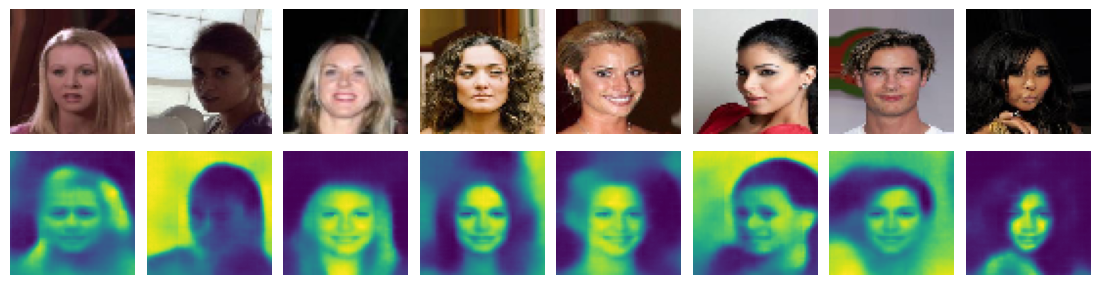

Epoch 1/12
791/791 [==============================] - 146s 185ms/step - batch: 395.5000 - size: 255.8068 - loss: 264.5114 - r_loss: 0.0211 - kl_loss: 53.0513
Epoch 2/12
791/791 [==============================] - 144s 183ms/step - batch: 395.5000 - size: 255.8068 - loss: 264.3182 - r_loss: 0.0211 - kl_loss: 53.1273
Epoch 3/12
791/791 [==============================] - 144s 181ms/step - batch: 395.5000 - size: 255.8068 - loss: 264.1558 - r_loss: 0.0211 - kl_loss: 53.1843
Epoch 4/12
791/791 [==============================] - 144s 182ms/step - batch: 395.5000 - size: 255.8068 - loss: 263.9491 - r_loss: 0.0211 - kl_loss: 53.2420
Epoch 5/12
791/791 [==============================] - 146s 184ms/step - batch: 395.5000 - size: 255.8068 - loss: 263.7992 - r_loss: 0.0210 - kl_loss: 53.3147
Epoch 6/12
791/791 [==============================] - 145s 183ms/step - batch: 395.5000 - size: 255.8068 - loss: 263.6173 - r_loss: 0.0210 - kl_loss: 53.3981
Epoch 7/12
791/791 [==============================] 

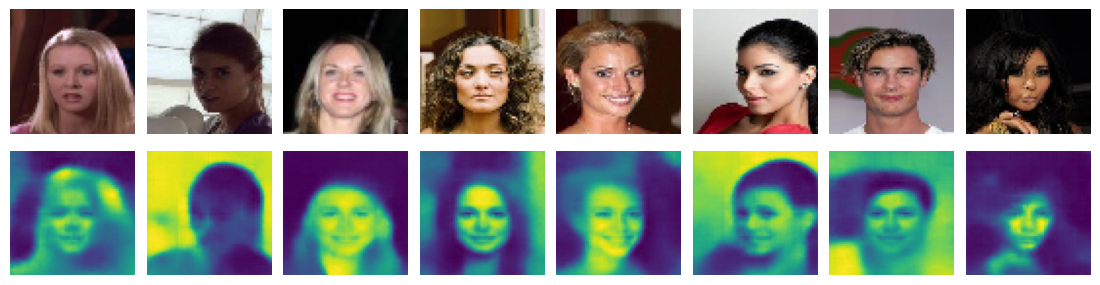

Epoch 1/12
791/791 [==============================] - 123s 155ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.6920 - r_loss: 0.0209 - kl_loss: 53.7300
Epoch 2/12
791/791 [==============================] - 132s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.5584 - r_loss: 0.0209 - kl_loss: 53.7626
Epoch 3/12
791/791 [==============================] - 123s 155ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.4795 - r_loss: 0.0209 - kl_loss: 53.7667
Epoch 4/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.3874 - r_loss: 0.0209 - kl_loss: 53.7793
Epoch 5/12
791/791 [==============================] - 123s 155ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.2726 - r_loss: 0.0208 - kl_loss: 53.8191
Epoch 6/12
791/791 [==============================] - 131s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.2262 - r_loss: 0.0208 - kl_loss: 53.8347
Epoch 7/12
791/791 [==============================] 

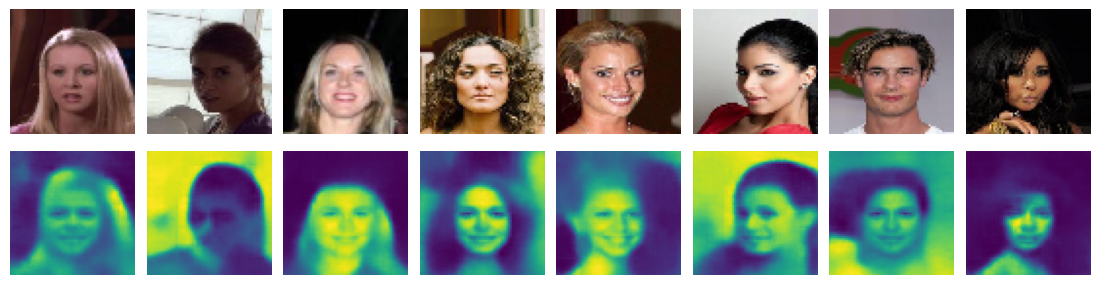

Epoch 1/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.6360 - r_loss: 0.0208 - kl_loss: 53.9092
Epoch 2/12
791/791 [==============================] - 141s 178ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.6158 - r_loss: 0.0208 - kl_loss: 53.9520
Epoch 3/12
791/791 [==============================] - 140s 176ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.5601 - r_loss: 0.0208 - kl_loss: 53.9568
Epoch 4/12
791/791 [==============================] - 142s 179ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.4947 - r_loss: 0.0208 - kl_loss: 53.9858
Epoch 5/12
791/791 [==============================] - 141s 178ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.4222 - r_loss: 0.0207 - kl_loss: 53.9733
Epoch 6/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.3709 - r_loss: 0.0207 - kl_loss: 53.9777
Epoch 7/12
791/791 [==============================] 

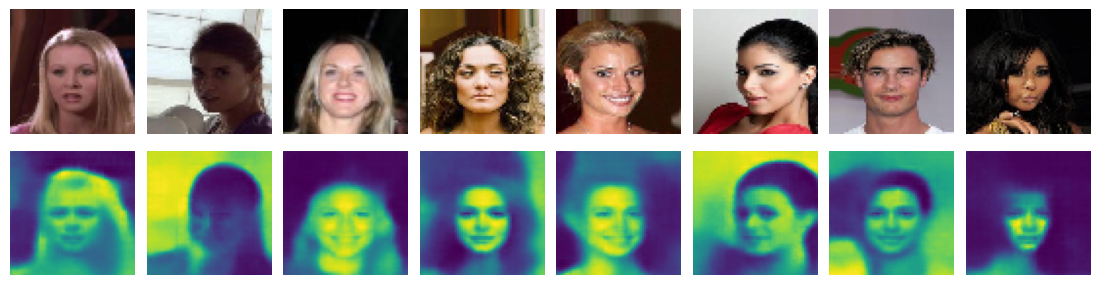

Epoch 1/12
791/791 [==============================] - 125s 158ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.0280 - r_loss: 0.0207 - kl_loss: 54.0377
Epoch 2/12
791/791 [==============================] - 126s 158ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.0409 - r_loss: 0.0207 - kl_loss: 54.0518
Epoch 3/12
791/791 [==============================] - 122s 154ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.9454 - r_loss: 0.0207 - kl_loss: 54.0578
Epoch 4/12
791/791 [==============================] - 124s 157ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.8877 - r_loss: 0.0207 - kl_loss: 54.0454
Epoch 5/12
791/791 [==============================] - 125s 158ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.8938 - r_loss: 0.0207 - kl_loss: 54.0652
Epoch 6/12
791/791 [==============================] - 127s 160ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.8173 - r_loss: 0.0207 - kl_loss: 54.0399
Epoch 7/12
791/791 [==============================] 

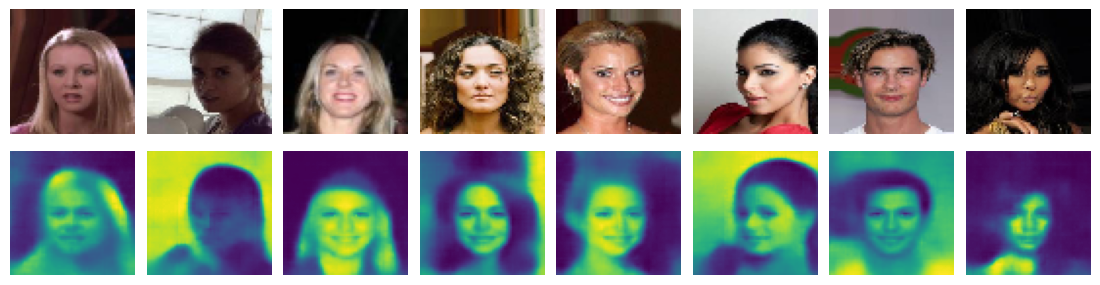

Epoch 1/12
791/791 [==============================] - 135s 170ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.5588 - r_loss: 0.0206 - kl_loss: 54.0782
Epoch 2/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.5654 - r_loss: 0.0206 - kl_loss: 54.1002
Epoch 3/12
791/791 [==============================] - 143s 181ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.4759 - r_loss: 0.0206 - kl_loss: 54.0665
Epoch 4/12
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.5266 - r_loss: 0.0206 - kl_loss: 54.1095
Epoch 5/12
791/791 [==============================] - 144s 182ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.4415 - r_loss: 0.0206 - kl_loss: 54.1103
Epoch 6/12
791/791 [==============================] - 144s 182ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.4412 - r_loss: 0.0206 - kl_loss: 54.1058
Epoch 7/12
791/791 [==============================] 

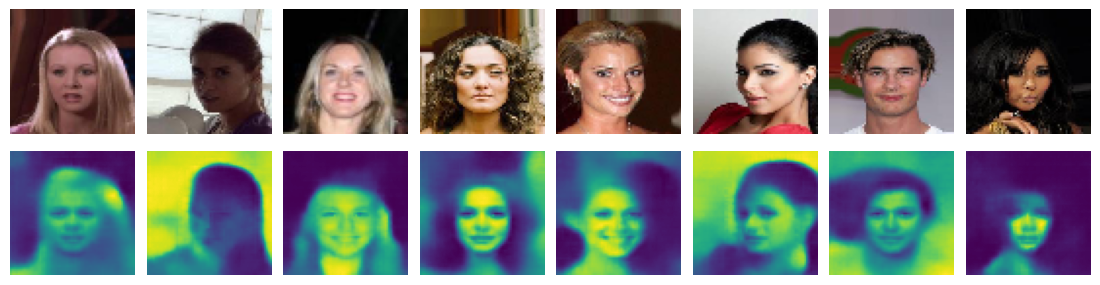

Epoch 1/12
791/791 [==============================] - 145s 183ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.2595 - r_loss: 0.0206 - kl_loss: 54.1608
Epoch 2/12
791/791 [==============================] - 133s 168ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.2045 - r_loss: 0.0206 - kl_loss: 54.1358
Epoch 3/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.2136 - r_loss: 0.0206 - kl_loss: 54.1694
Epoch 4/12
791/791 [==============================] - 122s 154ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.1801 - r_loss: 0.0206 - kl_loss: 54.1513
Epoch 5/12
791/791 [==============================] - 131s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.1071 - r_loss: 0.0206 - kl_loss: 54.1711
Epoch 6/12
791/791 [==============================] - 123s 155ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.1288 - r_loss: 0.0206 - kl_loss: 54.1725
Epoch 7/12
791/791 [==============================] 

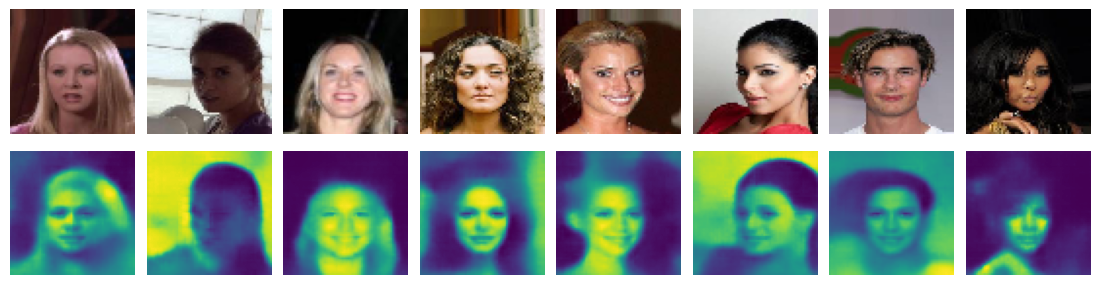

Epoch 1/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.9774 - r_loss: 0.0206 - kl_loss: 54.1981
Epoch 2/12
791/791 [==============================] - 128s 162ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.9607 - r_loss: 0.0206 - kl_loss: 54.2231
Epoch 3/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.9190 - r_loss: 0.0206 - kl_loss: 54.1931
Epoch 4/12
791/791 [==============================] - 134s 169ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.9561 - r_loss: 0.0206 - kl_loss: 54.2174
Epoch 5/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.9209 - r_loss: 0.0206 - kl_loss: 54.2136
Epoch 6/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.8600 - r_loss: 0.0206 - kl_loss: 54.2090
Epoch 7/12
791/791 [==============================] 

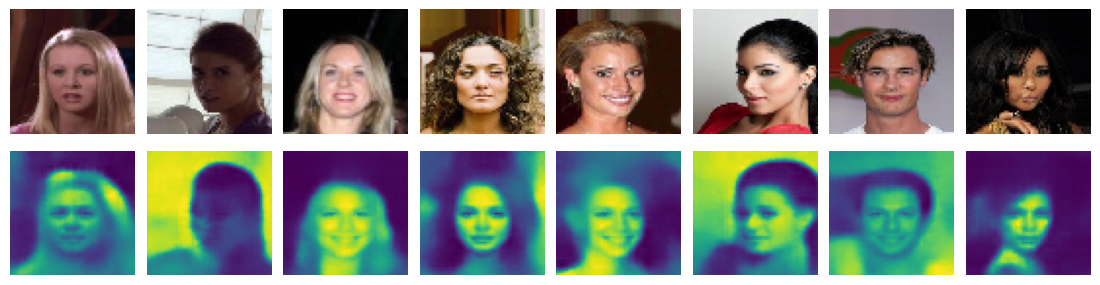

Epoch 1/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.7605 - r_loss: 0.0206 - kl_loss: 54.2389
Epoch 2/12
791/791 [==============================] - 141s 178ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.7410 - r_loss: 0.0206 - kl_loss: 54.2264
Epoch 3/12
791/791 [==============================] - 138s 174ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.7342 - r_loss: 0.0205 - kl_loss: 54.2341
Epoch 4/12
791/791 [==============================] - 144s 182ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.7263 - r_loss: 0.0205 - kl_loss: 54.2407
Epoch 5/12
791/791 [==============================] - 138s 174ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.6908 - r_loss: 0.0205 - kl_loss: 54.2326
Epoch 6/12
791/791 [==============================] - 131s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.6855 - r_loss: 0.0205 - kl_loss: 54.2455
Epoch 7/12
791/791 [==============================] 

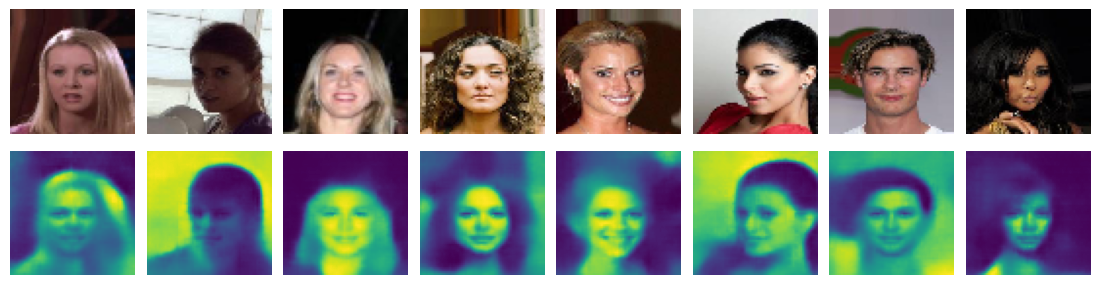

Epoch 1/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.5620 - r_loss: 0.0205 - kl_loss: 54.2523
Epoch 2/12
791/791 [==============================] - 131s 165ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.5486 - r_loss: 0.0205 - kl_loss: 54.2520
Epoch 3/12
791/791 [==============================] - 132s 167ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.5572 - r_loss: 0.0205 - kl_loss: 54.2490
Epoch 4/12
791/791 [==============================] - 131s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.5424 - r_loss: 0.0205 - kl_loss: 54.2744
Epoch 5/12
791/791 [==============================] - 131s 165ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.5398 - r_loss: 0.0205 - kl_loss: 54.2534
Epoch 6/12
791/791 [==============================] - 131s 165ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.4899 - r_loss: 0.0205 - kl_loss: 54.2540
Epoch 7/12
791/791 [==============================] 

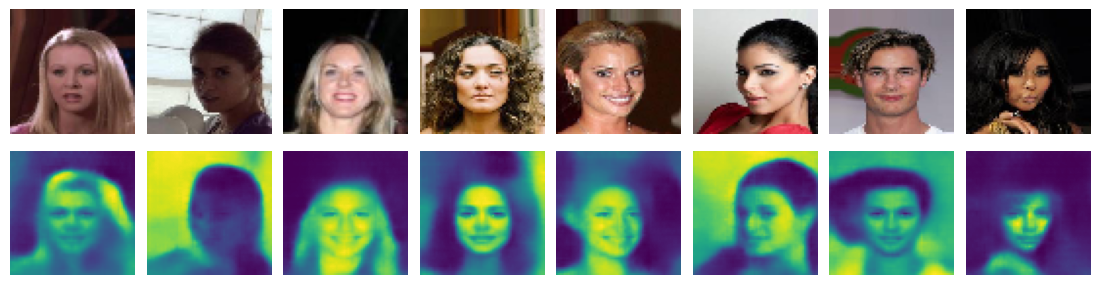

Epoch 1/12
791/791 [==============================] - 140s 176ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.4074 - r_loss: 0.0205 - kl_loss: 54.2642
Epoch 2/12
791/791 [==============================] - 142s 178ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.4256 - r_loss: 0.0205 - kl_loss: 54.2688
Epoch 3/12
791/791 [==============================] - 136s 172ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.4557 - r_loss: 0.0205 - kl_loss: 54.2780
Epoch 4/12
791/791 [==============================] - 176s 223ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.4118 - r_loss: 0.0205 - kl_loss: 54.2796
Epoch 5/12
791/791 [==============================] - 142s 179ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.3761 - r_loss: 0.0205 - kl_loss: 54.2656
Epoch 6/12
791/791 [==============================] - 144s 182ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.3845 - r_loss: 0.0205 - kl_loss: 54.2732
Epoch 7/12
791/791 [==============================] 

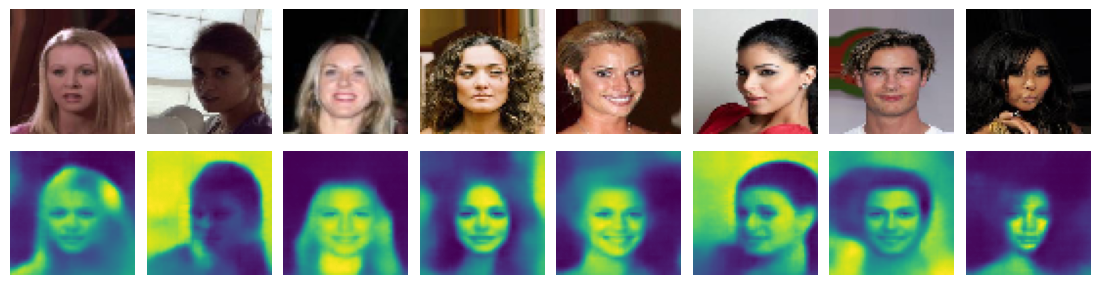

Epoch 1/12
791/791 [==============================] - 131s 165ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.3411 - r_loss: 0.0205 - kl_loss: 54.2965
Epoch 2/12
791/791 [==============================] - 129s 163ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.3324 - r_loss: 0.0205 - kl_loss: 54.2968
Epoch 3/12
791/791 [==============================] - 131s 165ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.2789 - r_loss: 0.0205 - kl_loss: 54.2919
Epoch 4/12
791/791 [==============================] - 129s 162ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.3010 - r_loss: 0.0205 - kl_loss: 54.2935
Epoch 5/12
791/791 [==============================] - 130s 164ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.2754 - r_loss: 0.0205 - kl_loss: 54.2841
Epoch 6/12
791/791 [==============================] - 128s 162ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.2669 - r_loss: 0.0205 - kl_loss: 54.3156
Epoch 7/12
791/791 [==============================] 

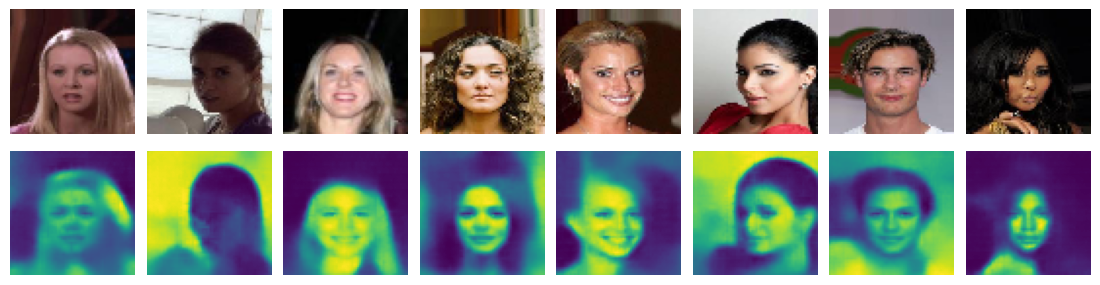

Epoch 1/12
791/791 [==============================] - 138s 174ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1882 - r_loss: 0.0205 - kl_loss: 54.3027
Epoch 2/12
791/791 [==============================] - 143s 181ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.2049 - r_loss: 0.0205 - kl_loss: 54.3168
Epoch 3/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1558 - r_loss: 0.0205 - kl_loss: 54.2998
Epoch 4/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1761 - r_loss: 0.0205 - kl_loss: 54.3191
Epoch 5/12
791/791 [==============================] - 140s 176ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1685 - r_loss: 0.0205 - kl_loss: 54.2972
Epoch 6/12
791/791 [==============================] - 140s 177ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1511 - r_loss: 0.0205 - kl_loss: 54.3154
Epoch 7/12
791/791 [==============================] 

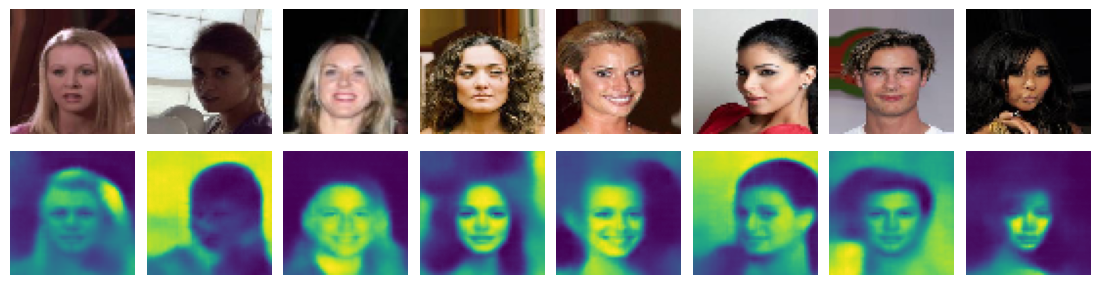

Epoch 1/12
791/791 [==============================] - 134s 169ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1172 - r_loss: 0.0205 - kl_loss: 54.3277
Epoch 2/12
791/791 [==============================] - 131s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1108 - r_loss: 0.0205 - kl_loss: 54.3294
Epoch 3/12
791/791 [==============================] - 131s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0748 - r_loss: 0.0205 - kl_loss: 54.3232
Epoch 4/12
791/791 [==============================] - 131s 165ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0913 - r_loss: 0.0205 - kl_loss: 54.3342
Epoch 5/12
791/791 [==============================] - 131s 166ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0676 - r_loss: 0.0205 - kl_loss: 54.3024
Epoch 6/12
791/791 [==============================] - 130s 164ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0228 - r_loss: 0.0205 - kl_loss: 54.3351
Epoch 7/12
791/791 [==============================] 

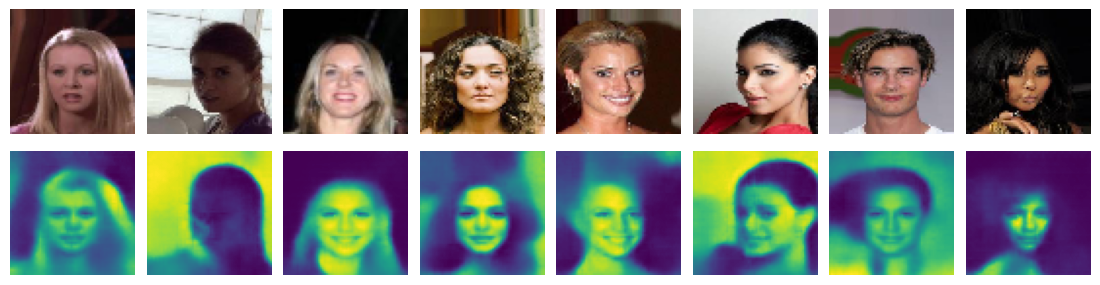

Epoch 1/12
791/791 [==============================] - 132s 167ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0303 - r_loss: 0.0205 - kl_loss: 54.3626
Epoch 2/12
542/791 [===================>..........] - ETA: 44s - batch: 270.5000 - size: 255.7177 - loss: 259.0520 - r_loss: 0.0205 - kl_loss: 54.3243

KeyboardInterrupt: 

In [25]:
# For each block train the model for a number of epochs and show the partial images
for i in range(N_BLOCKS):
    hist = vae.fit(data_flow, 
        shuffle=True, 
        epochs = N_EPOCHS, 
        initial_epoch = 0, 
        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)
    hist_loss.append(hist.history['loss'])
    hist_r_loss.append(hist.history['r_loss'])
    hist_kl_loss.append(hist.history['kl_loss'])

    plot_compare_VAE(example_images) 

In [38]:
f_hist_loss = []
for h in hist_loss:
    for v in h:
        f_hist_loss.append(v)

f_hist_r_loss = []
for h in hist_r_loss:
    for v in h:
        f_hist_r_loss.append(v)

f_hist_kl_loss = []
for h in hist_kl_loss:
    for v in h:
        f_hist_kl_loss.append(v)

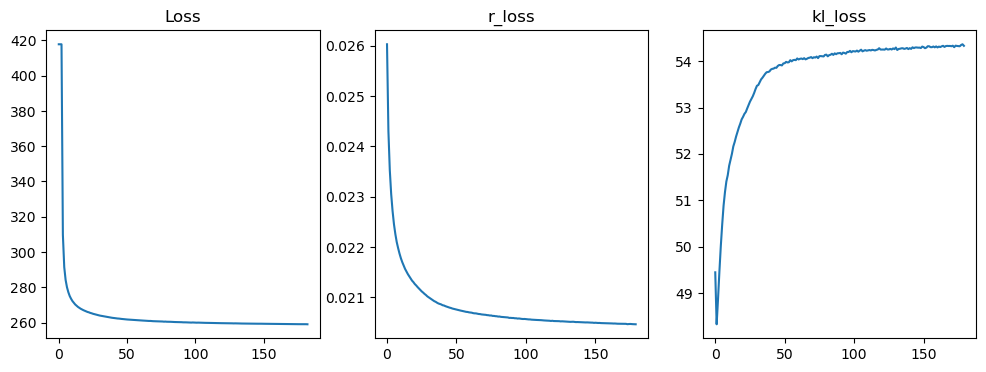

In [40]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot the data on each subplot
ax1.plot(f_hist_loss)
ax2.plot(f_hist_r_loss)
ax3.plot(f_hist_kl_loss)

# Add titles to each subplot
ax1.set_title('Loss')
ax2.set_title('r_loss')
ax3.set_title('kl_loss')

plt.show()

In [ ]:
# TODO try different learning rate?

In [ ]:
# TODO try different Conv?